# Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes: cubic building

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

In [2]:
l = 3               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls

In [3]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)

In [4]:
concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface': 5 * l**2}

insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210,
              'Width': 0.08,
              'Surface': 5 * l**2}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.04,
         'Surface': l**2}

wall = pd.DataFrame.from_dict({'Layer_out': insulation,
                               'Layer_in': concrete,
                               'Glass': glass},
                              orient='index')

In [5]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

In [6]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

In [7]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)

In [8]:
# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']

In [9]:
# convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

In [10]:
# view factor wall-glass
Fwg = glass['Surface'] / concrete['Surface']

In [11]:
# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

In [12]:
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

In [13]:
# ventilation flow rate
Va = l**3                   # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

In [14]:
# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

In [15]:
# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0
Kp = 0

In [16]:
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

In [17]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']

In [18]:
C['Air'] = air['Density'] * air['Specific heat'] * Va

In [19]:
A = np.zeros([12, 8])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6

In [20]:
G = np.diag(np.hstack(
    [Gw['out'],
     2 * G_cd['Layer_out'], 2 * G_cd['Layer_out'],
     2 * G_cd['Layer_in'], 2 * G_cd['Layer_in'],
     GLW,
     Gw['in'],
     Gg['in'],
     Ggs,
     2 * G_cd['Glass'],
     Gv,
     Kp]))

In [21]:
neglect_air_glass = False

if neglect_air_glass:
    C = np.diag([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                 0, 0])
else:
    C = np.diag([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                 C['Air'], C['Glass']])

In [22]:
b = np.zeros(12)        # branches
b[[0, 8, 10, 11]] = 1   # branches with temperature sources
print(f'b = ', b)

b =  [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]


In [23]:
f = np.zeros(8)         # nodes
f[[0, 4, 6, 7]] = 1     # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 0. 0. 0. 1. 0. 1. 1.]


In [24]:
y = np.zeros(8)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 0. 0. 0. 0. 1. 0.]


The [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation), i.e., matrices $A_s, B_s, C_s, D_s$ is obtained from the system of DAE, i.e., matrices and vectors $A, G, b, C, f, y$ ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)).

In [25]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, C, b, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-2.44403914e-04  1.20952723e-04  0.00000000e+00  0.00000000e+00]
 [ 1.59079125e-06 -1.50649103e-05  1.22080436e-05  1.26607539e-06]
 [ 0.00000000e+00  6.86363341e-03 -9.42774014e-03  2.28632896e-03]
 [ 0.00000000e+00  2.11779883e-05  6.80230103e-05 -2.41441103e-04]] 

Bs = 
 [[1.23451191e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.09734392e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.35093036e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.77777778e-04 0.00000000e+00
  0.00000000e+00 1.08946562e-05 3.08641975e-05 0.00000000e+00]
 [0.00000000e+00 1.52240104e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.36158545e-08 0.00000000e+00 9.18273646e-07]] 

Cs = 
 [[0. 0. 1. 0.]] 

Ds = 
 [[0. 0. 0. 0. 0. 0. 0. 0.]] 



In [26]:
b = np.zeros(12)        # temperature sources
b[[0, 8, 10]] = 10      # outdoor temperature
b[[11]] = 20            # indoor set-point temperature

f = np.zeros(8)         # flow-rate sources

In [27]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C


In [28]:
bT = np.array([10, 10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0])         # [Φo, Φi, Qa, Φa]
u = np.hstack([bT, fQ])

In [29]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u

In [30]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[6] - yss)):.2e} °C')

Max error between DAE and state-space: 2.13e-14 °C


## Dynamic simulation

In [31]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [1.05781075e+02 2.48789578e+05 4.07728197e+03 4.42708370e+03] s 

2 x Time constants: 
 [2.11562150e+02 4.97579156e+05 8.15456394e+03 8.85416739e+03] s 

Maximum time step: 211.56 s = 3.53 min


Let's chose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i) $.

In [32]:
# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 180.0 s = 3 min


In [33]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [   420  16308  17708 995156] s 

Settling time: 995158 s = 16586.0 min = 276.43 h = 11.52 days


In [34]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 997200.0 s
Number of time steps = 5540


In [35]:
u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps

# pd.DataFrame(u)

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [36]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [37]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

The results of explicit and implicit Euler integration are practically identical.

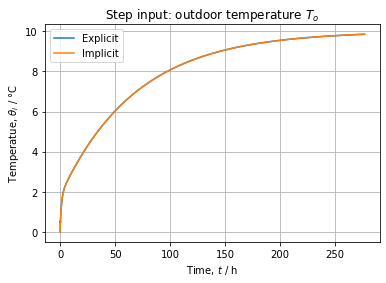

In [38]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()

> Figure 7. Step response to outdoor temperature by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

The value the indoor temperature obtained after the [settling time](https://en.m.wikipedia.org/wiki/Settling_time) is almost equal to the value obtained in steady-state.

In [39]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 9.8512 °C


### Simulation with weather data

In [40]:
start_date = '02-01 12:00:00'
end_date = '02-07 18:00:00'

In [41]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-02-01 12:00:00 	start date
2000-02-07 18:00:00 	end date


#### Inputs
##### Read weather data

In [42]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

In [43]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

In [44]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)

The total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance)  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

In [45]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)

In [46]:
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
data = data.rename_axis('Time')
# pd.DataFrame(data)

In [47]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
# pd.DataFrame(data)

In [48]:
# input vector
To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Layer_out'] * data['Φtot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Φtot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Φtot']

u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
# pd.DataFrame(u)

In [49]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

In [50]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

In [51]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

In [52]:
data['θi_exp'] = y_exp.T
data['q_HVAC'] = q_HVAC.T

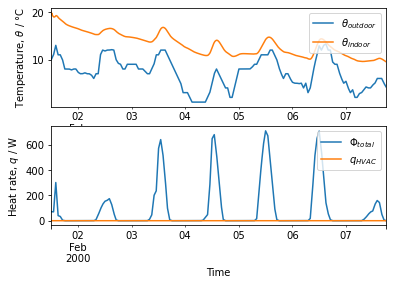

In [53]:
fig, axs = plt.subplots(2, 1)

data[['To', 'θi_exp']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()

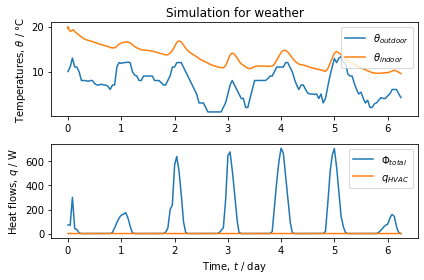

In [54]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot'], label='$Φ_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()